# TP4: Travail Final 
## VANBELLE Julien

## Imports

In [1]:
import os
import yake
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.corpus import webtext
nltk.download('stopwords')
nltk.download('webtext')
from IPython.display import Image
from collections import defaultdict
import sys
import spacy
from spacy.lang.fr.examples import sentences
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
from tabulate import tabulate

txt_path = '/Users/julienvanbelle/Documents/GitHub/tac/data/txt'
data_path = '/Users/julienvanbelle/Documents/GitHub/tac/data'


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julienvanbelle/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package webtext to
[nltk_data]     /Users/julienvanbelle/nltk_data...
[nltk_data]   Package webtext is already up-to-date!


## Data cleaning

In [2]:
files = os.listdir(txt_path)
data_bxl = [f for f in files]
len(data_bxl)


2831

In [3]:
data_list = []
for txt in data_bxl:
    with open(os.path.join(txt_path, txt), 'r', encoding = "ISO-8859-1") as f:
        data_list.append(f.read())

len(data_list)


2831

In [4]:
# Ecrire tout le contenu dans un fichier temporaire
if not os.path.exists(data_path):
    os.mkdir(data_path)
with open(os.path.join(data_path, f'_temp.txt'), 'w') as f:
    f.write(' '.join(data_list))
    print("temp file saved in",data_path)

temp file saved in /Users/julienvanbelle/Documents/GitHub/tac/data


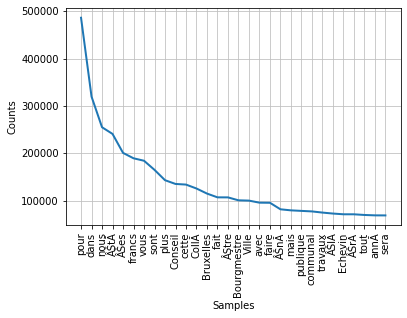

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [5]:
wt_words = webtext.words('{}/_temp.txt'.format(data_path))
data_analysis = nltk.FreqDist(wt_words)
 
filter_words = dict([(m, n) for m, n in data_analysis.items() if len(m) > 3])

##for key in sorted(filter_words):
    ##print("%s: %s" % (key, filter_words[key]))
 
data_analysis = nltk.FreqDist(filter_words)
data_analysis.plot(30, cumulative=False)

In [6]:
addsw = []
for z in sorted(filter_words):
  if filter_words[z] > 25000:
   ##print("%s: %s" % (z, filter_words[z]))
   addsw.append(z)

print(addsw)

['Administration', 'Bourgmestre', 'Bruxelles', 'Cette', 'CollĂ', 'Commission', 'Conseil', 'Echevin', 'Ecole', 'Etat', 'Mais', 'Messieurs', 'Monsieur', 'Nous', 'Saint', 'Section', 'Service', 'SociĂ', 'Total', 'Ville', 'administration', 'adoptĂ', 'ainsi', 'annĂ', 'aprĂ', 'arrĂ', 'article', 'aussi', 'autre', 'autres', 'avait', 'avant', 'avec', 'avenue', 'avis', 'avoir', 'avons', 'bien', 'budget', 'cela', 'celle', 'celui', 'cette', 'ceux', 'charges', 'comme', 'communal', 'communale', 'communes', 'compte', 'conditions', 'considĂ', 'contre', 'cours', 'crois', 'dans', 'demande', 'depuis', 'deux', 'dire', 'divers', 'doit', 'donc', 'donnĂ', 'dont', 'droit', 'elle', 'encore', 'enfants', 'entre', 'entretien', 'exercice', 'faire', 'fait', 'faut', 'favorable', 'frais', 'francs', 'glement', 'heures', 'honneur', 'intĂ', 'jour', 'leur', 'leurs', 'lieu', 'mais', 'mars', 'membres', 'moins', 'mois', 'nombre', 'notre', 'nous', 'octobre', 'ordre', 'part', 'partie', 'pendant', 'personnel', 'peut', 'place', 

In [7]:
# Stopwords
swLower = ' '.join(str(e).lower() for e in addsw)
sw = stopwords.words("french")
sw += addsw
sw += swLower
sw += "conseil communal", "conseil général", "conseil supérieur", "administration communale", "conseil provincial", "l'administration communale", "conseil", "echevin" , "messieurs", "bruxelles", "bourgmestre", "collège", "être"
sw = set(sw)
print(sw)

{'ayants', 'communes', 'votre', 'soit', 'publique', ' ', 'Bourgmestre', 'aura', 'aurai', 'Administration', 'qui', 'et', 'que', 'SociĂ', 'on', 'ton', 'rapport', 'leurs', 'mars', 'frais', 'êtes', 'charges', 'ayons', 'étiez', 'avenue', 'ce', 'o', 'publics', 'eusses', 'crois', 'part', 'service', 'ÂŠcole', 'ses', 'plus', 'étante', 'aurait', 'encore', 'moi', 'intĂ', 'eurent', 'ÂŞtĂ', 'avez', 'autres', 'ÂŠcembre', 'CollĂ', 'prix', 'Cette', 'supplĂ', 'eus', 'une', 'eux', 'auriez', 'Ecole', 'ainsi', 'le', 'travaux', 'eue', 'mois', 'point', 'fûmes', 'dans', 'ÂŠlĂ', 'auront', 'suite', 'administration communale', 'serais', 'ÂŠtait', 'est', 'ÂŞtre', 'ÂŠration', 'bourgmestre', 'exercice', 'lieu', 'fusses', 'ÂŠcĂ', 'fus', 'tres', 'serons', 'eussent', 'communal', 'du', 'fussiez', 'ait', 'proposition', 'tes', 'seriez', 'tout', 'nombre', 'echevin', 'aurais', 'enfants', 'eues', 'pendant', 'seront', 'notre', 'collège', 'budget', 'furent', 'Etat', 'conditions', 'p', 's', 'seras', 'i', 'elle', 'eûmes', 'avi

In [23]:
def clean_text(folder=None):
    if folder is None:
        input_path = f".txt"
        output_path = f"_clean.txt"
    else:
        input_path = f"{folder}/_temp.txt"
        output_path = f"{folder}/_clean.txt"
    output = open(output_path, "w", encoding="ISO-8859-1")
    with open(input_path, encoding="ISO-8859-1") as f:
        text = f.read()
        words = nltk.wordpunct_tokenize(text)
        kept = [w.lower() for w in words if len(w) > 2 and w.isalpha() and w.lower() not in sw]
        kept_string = " ".join(kept)
        output.write(kept_string)
    return f'Output has been written in {output_path}!'

In [24]:
clean_text(folder=data_path)

'Output has been written in /Users/julienvanbelle/Documents/GitHub/tac/data/_clean.txt!'

In [27]:
# Vérifier le résultat
with open(os.path.join(data_path, f'_clean.txt'), 'r', encoding="ISO-8859-1") as f:
    after = f.read()

after[:5000]

'vii âªtes quartier comitã quartier preuve habituelle activitã long tannã manifestations telles cortã ges bals populaires attractions foraines jeux populaires concerts promenades concerts kiosques contribuã largement succã âªtes remportã suffrages ritã population mis gracieusement kiosques disposition comitã outre parti saison cercles intã âªts matã riels dessous dates âªtes organisã comitã quartier annã district union commerã ants nord bourse juin septembre hiver association fense activitã economiques centre art commerce industrie juillet entente commerã ants rue haute septembre commune libre marolles minimes attractions juin amicale commerã ants artisans artã res centrales bourse midi rues adjacentes cembre janvier compagnons saint laurentã meyboom aoã association dame rouge extension aoã septembre union commerã ants rues flandre sainte catherine adjacentes septembre union commerã ants sainã bourse septembre rue blaes attraction mai juin septembre renard attraction septembre comitã c